In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from math import log
from pathlib import Path
from matplotlib import pyplot as plt
from copy import deepcopy

In [ ]:
date_str = "2020-03-18_2020-03-22"
base_path = Path("/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston_gengraph/")
test = base_path / date_str / f"{date_str}.xml"
sequences = base_path / date_str / f"{date_str}_seq_input.txt"
with open(sequences) as src:
    sequences = len(src.readlines()) - 1
test = nx.read_graphml(test)
sequences

In [ ]:
nx.draw(test, with_labels=True, font_weight='bold')

In [ ]:
test_path = Path("/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/test")
same = test_path / "test_same.xml"
same = nx.read_graphml(same)
nx.draw(same, with_labels=True)
l = ""
for node in same.nodes():
    l += same.nodes[node]["sequence"]
l

In [44]:
def expand_ggraph(ggraph):
    """
    Expand the graph from normal run of GrnGraph so each node is a nucleotide
    """
    new_graph = nx.DiGraph()
    entry_points = {node:None for node in ggraph.nodes()}
    
    for node in ggraph.nodes():
        
        node_info = ggraph.nodes[node]
        
        if entry_points[node] is None:
            last_node = None
            entry_points[node] = node + "_0"
            start_idx = 0
        else:
            last_node = entry_points[node]
            start_idx = 1
            
        ids = set(ggraph.nodes[node]["ids"].split(","))
        num_genomes = len(ids)
        for ix, character in enumerate(node_info["sequence"][start_idx:]):
            ix += start_idx
            new_node = node + "_" + str(ix)
#             new_graph.add_node(new_node, attr_dict={"sequence":character, "num_genomes":num_genomes})
            new_graph.add_node(new_node, sequence = character, num_genomes = num_genomes)
            if last_node is not None:
                new_graph.add_edge(last_node, new_node, weight=num_genomes)
            last_node = new_node

        for child in ggraph.successors(node):
            child_info = ggraph.nodes[child]
            child_ids = set(child_info["ids"].split(","))
            
            entry_point = entry_points[child]
            if entry_point is not None:
                new_graph.add_edge(last_node, entry_point, weight=len(ids & child_ids))
            else:

                child_node = child + "_0"
#                 new_graph.add_node(child_node, attr_dict={"sequence":child_info["sequence"][0], "num_genomes":len(child_info["ids"].split(","))})
                new_graph.add_node(child_node, sequence=child_info["sequence"][0], num_genomes=len(child_info["ids"].split(",")))
                entry_points[child] = child_node
                new_graph.add_edge(last_node, child_node, weight=len(ids & child_ids))
                
    return new_graph
        
def add_root(ggraph, num_genomes):
    no_in_nodes = []
    for node in ggraph.nodes():
        if ggraph.in_degree(node) == 0:
            no_in_nodes.append(node)
    if len(no_in_nodes) == 1:
        return no_in_nodes[0]
    else:
        ggraph.add_node("root", sequence="N", num_genomes=num_genomes)
        for node in no_in_nodes:
            ggraph.add_edge("root", node)
        return "root", no_in_nodes

def get_complement_nodes(ggraph, x_node): #, num_genomes):
    #Could benefit from some indexing
    #Could optimize by finding the consensus nodes and stopping 
    #     early there since all above or below are "implied"
    #     but would need to potentially iterate over the nodes 
    #     again since switching from negation to inclusion
    node_states = {node:True for node in ggraph.nodes}
        
    def follow_ancestors(node):
        if node_states[node] or node == x_node: #stop if node already visited
            node_states[node] = False
            for anc_node in ggraph.predecessors(node):
                follow_ancestors(anc_node)
            
    def follow_descendants(node):
        if node_states[node] or node == x_node: #stop if node already visited
            node_states[node] = False
            for dec_node in ggraph.successors(node):
                follow_descendants(dec_node)
    
    follow_ancestors(x_node)
    follow_descendants(x_node)
    
    return [node for node in node_states if node_states[node]]

def calc_node_chars(ggraph, node):
    return len(ggraph.nodes[node]["sequence"]) * ggraph.nodes[node]["num_genomes"]

def calc_uncertainty(ggraph, num_chars=None): #, num_genomes):
    
    char_per_node = False
    
    if num_chars is None: #Use each node as a character
        num_chars = len(graph.nodes())
        char_per_node = True
    
    uncert = 0
    
    for x_node in ggraph.nodes():
        x_node_info = ggraph.nodes[x_node]
        x_node_characters = 1 if char_per_node else calc_node_chars(ggraph, x_node)
        
        x_uncert = x_node_characters / num_chars
        
        #For the first term
        uncert -= x_uncert * log( x_uncert , 2)
        
        #For the second term
        y_nodes = get_complement_nodes(ggraph, x_node)
        y_set_chars = len(y_nodes) if char_per_node else sum([calc_node_chars(ggraph, y_node) for y_node in y_nodes])
        for y_node in y_nodes:
            
            y_node_characters = 1 if char_per_node else calc_node_chars(ggraph, y_node)
            y_uncert = ( y_node_characters / y_set_chars )
            
            uncert -= x_uncert * y_uncert * log( y_uncert , 2)
            
    return uncert

Currently calculates:

$ -\log_{2} \frac{1}{Nodes} + \frac{1}{Nodes} \sum_{x}^{Nodes} -\log_{2}\frac{1}{\# nodes\_not\_connected\_to\_i} $

Need to do: 

$ -\sum_{x}^{Nodes} \frac{C_x}{C} \log_{2} \frac{C_x}{C} - \sum_{x}^{Nodes}\sum_{y}^{\overline{G_x}} \frac{C_x}{C} \frac{C_y}{C_{\overline{G_x}}} \log_{2}\frac{C_y}{C_{\overline{G_x}}}$

Where $C$ is the number of characters ($G*alignment\_len$) in the graph, $C_x$ is the number of characters going through node $x$ and ${\overline{G_x}}$ is the set of nodes which are not descendants or ancestors of $x$ (alternate implementation: which contain none of the genomes in $x$)

In [64]:
# seq_paths = ['/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-793.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-792.fasta']
seq_paths = ['/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26102.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31049.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26155.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26182.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26335.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31013.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26322.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30789.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26237.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31086.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30798.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26208.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30997.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26235.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26358.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26122.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30718.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30762.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31039.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26271.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26261.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30891.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26288.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30765.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26275.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26233.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26183.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30879.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30867.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26307.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26187.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31035.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26227.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26118.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26176.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31081.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30963.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31094.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30955.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30773.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26164.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30799.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30934.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30768.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26294.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26216.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26309.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26221.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26100.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26368.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26301.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30882.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30937.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31057.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30869.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31073.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31058.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26101.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31078.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26296.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26241.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26194.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26336.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26201.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30949.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26249.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30842.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26280.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26163.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26295.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26130.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26178.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31046.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26174.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26351.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30914.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26344.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30904.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30711.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26180.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26316.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26319.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26108.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26248.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26293.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26264.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30714.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26262.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30771.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26211.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26198.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30938.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26196.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30719.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26223.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26165.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26324.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26160.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30783.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26134.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30887.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26245.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26361.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26303.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26179.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31089.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26230.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26289.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30712.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26347.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26175.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26272.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26111.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30809.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26150.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26311.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30828.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30825.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31088.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31041.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30977.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30992.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26363.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31083.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26326.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26112.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30915.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30924.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30961.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30819.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30778.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26274.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26139.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26218.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26353.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26156.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30950.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30787.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31032.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30731.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26127.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31075.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26097.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31093.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26096.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30920.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26337.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30919.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30917.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30918.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26334.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26120.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26206.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30884.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26204.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26202.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26129.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31015.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30980.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30871.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26192.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30932.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30821.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26258.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26209.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31085.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26166.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26254.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26260.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26354.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26207.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26141.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26357.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26137.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26346.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31072.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26340.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26282.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30928.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30816.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31092.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26116.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30854.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26140.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30979.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26219.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26177.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30930.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30817.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30940.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26222.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26184.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26285.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30803.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26220.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30908.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30885.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26121.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30720.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30713.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26267.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26243.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31064.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31047.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26253.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26117.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30889.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26217.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26159.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26273.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30909.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31017.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26328.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31016.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26190.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26302.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30966.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31077.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26213.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30943.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26105.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26277.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30820.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31026.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30880.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30717.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26110.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26268.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26244.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31059.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26333.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26152.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31060.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30823.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26145.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26215.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26193.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26170.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30866.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26224.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30881.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26200.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26115.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30814.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30948.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26138.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30946.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26318.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26119.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30913.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26329.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30995.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30933.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26109.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30910.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31076.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26350.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26125.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31052.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26149.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26364.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26135.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30870.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30929.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26299.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26276.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30818.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30886.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26310.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30807.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30954.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26185.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26132.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26252.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26298.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30796.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26142.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26338.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26136.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26345.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26365.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30748.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30815.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30931.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26205.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26114.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30969.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26278.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26348.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30874.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26315.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30877.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30749.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26331.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26320.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30826.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26231.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30883.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26263.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26167.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26279.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31069.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26154.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26128.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30907.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26266.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31043.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30878.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26352.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30987.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30947.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30808.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30905.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26144.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26255.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30715.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31037.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30830.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30994.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26304.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26321.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30988.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26123.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26104.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26191.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30761.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30747.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26226.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26148.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31062.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31080.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31038.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26317.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30998.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31036.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30926.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30898.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30939.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30923.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26168.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31087.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30973.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26236.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31061.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26240.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26242.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31028.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30853.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26300.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31063.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30978.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31042.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26186.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31071.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26195.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26199.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30964.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30760.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26158.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26360.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30876.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30991.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30764.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30906.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30975.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30811.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31091.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26147.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30795.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26308.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26366.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30972.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30945.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31051.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31019.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26284.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30888.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30786.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26339.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30801.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30890.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30921.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30759.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26370.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26330.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30804.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26143.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30763.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26305.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26151.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26126.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26292.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26287.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30812.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30936.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30868.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31040.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30894.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30911.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30873.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26259.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26189.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30840.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26356.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26169.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26157.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26283.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31022.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31067.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30960.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26173.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31082.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26238.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30956.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30897.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31021.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30792.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26355.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26290.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31074.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30893.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26203.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26197.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31034.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31044.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26228.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26214.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30959.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31020.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30903.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30892.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31053.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31050.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26341.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26246.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26171.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26239.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26256.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26314.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26098.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26161.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30716.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26349.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31056.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26106.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30935.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26099.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26133.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26367.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30902.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30872.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26172.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26131.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31066.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30968.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26270.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26306.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30895.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26181.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26332.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31014.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30865.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30824.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26325.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31070.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31030.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26225.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26286.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26327.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26234.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30967.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26342.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26323.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26153.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26281.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26188.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31023.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31025.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26229.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30829.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30925.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31065.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26291.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30912.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26162.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30767.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30993.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30822.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26257.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26212.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30942.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31048.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31084.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30899.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30800.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26113.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26343.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30784.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26210.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26107.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26359.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26146.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30957.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30990.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26251.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30810.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30732.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26313.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30989.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26103.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26247.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26232.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26362.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26265.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26250.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26269.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30927.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26124.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26297.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26369.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30900.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-26312.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-31068.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30802.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30791.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-MCoV-30901.fasta']
graph, num_chars = generate_nx_from_msa(seq_paths)

In [63]:
def generate_nx_from_msa(seq_paths):
    num_chars = 0
    genome_len = 34742 #54

    graph = nx.DiGraph()
    for ix in range(genome_len):
        for letter in ["A","T","C","G","N"]:
            graph.add_node(f"{ix}_{letter}", genomes=[], sequence=letter, num_genomes=0)

    for seq in seq_paths:
        with open(seq) as src:
            for line in src.readlines():
                line = line.strip()
                if line[0] == ">":
                    genome = line[1:] #.split("/")[2]
                else:

                    prev_node = None
                    num_chars += len(line)
                    for ix, char in enumerate(line): #[34000:35000]):
                        if char == "-":
                            char = "N" #Preserves overall length of genome graph
                            continue
                        if char not in ["A","T","C","G","N"]:
                            char = "N"
                        node = f"{ix}_{char}"
                        graph.nodes[node]["genomes"].append(genome)
                        graph.nodes[node]["num_genomes"] += 1
                        if prev_node is not None and node not in graph.successors(prev_node):
                            graph.add_edge(prev_node, node)
                        prev_node = node
    empty_nodes = []
    for node in graph.nodes():
        if not graph.nodes[node]["genomes"]:
            empty_nodes.append(node)
            
    graph.remove_nodes_from(empty_nodes)

#     bad_n_nodes = []
#     for node in graph.nodes:
#         ix, char = node.split("_")
#         if char == "N":
#             n_genomes = graph.nodes[node]["genomes"]
#             n_num_genomes = graph.nodes[node]["num_genomes"]
#             pop_node = None
#             pop_node_genomes = 0
#             for alt_node in [f"{ix}_{c}" for c in ["A","T","C","G"]]:
#                 try:
#                     node_genomes = len(graph.nodes[alt_node]["genomes"])
#                     if node_genomes > pop_node_genomes:
#                         pop_node = alt_node
#                         pop_node_genomes = node_genomes
#                 except:
#                     continue
#             if pop_node is not None:
#                 graph.nodes[pop_node]["genomes"].extend(n_genomes)
#                 graph.nodes[pop_node]["num_genomes"] += n_num_genomes
#                 bad_n_nodes.append(node)
#     graph.remove_nodes_from(bad_n_nodes)
    
    return graph, num_chars

In [65]:
# seqs = """TX-HMH-1002.fasta
# TX-HMH-1003.fasta
# TX-HMH-1004.fasta
# TX-HMH-1006.fasta
# TX-HMH-1007.fasta
# TX-HMH-1011.fasta
# TX-HMH-1012.fasta
# TX-HMH-1013.fasta
# TX-HMH-1016.fasta
# TX-HMH-1020.fasta""".split()
# houston_path = "/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/"
# seq_paths = [houston_path + seq for seq in seqs]  

# seqs = ["first", "second", "third", "fourth"]
# test_path = "/scratch/jho5ze/bionets/covid/data/test/"
# seq_paths = [test_path + seq + ".fasta" for seq in seqs] 
# print(" ".join(seq_paths))
# num_genomes = len(seqs)

seq_paths = ['/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-793.fasta', '/sfs/lustre/bahamut/scratch/jho5ze/bionets/covid/data/Houston/TX-HMH-792.fasta']

graph, num_chars = generate_nx_from_msa(seq_paths)
graph.add_node("X_X", num_genomes=1, sequence="N")
graph.add_edge("X_X", "4_C")
add_root(graph, num_genomes)
collapsed_graph = collapse_graph(graph)
nx.draw(collapsed_graph, with_labels=True)

In [54]:
nx.write_gpickle(collapsed_graph, "test.gpkl")

In [48]:
calc_uncertainty(collapsed_graph, num_chars=num_chars)

2.588340036742151

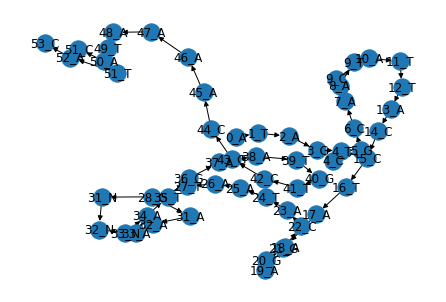

In [24]:
nx.draw(graph, with_labels=True)

In [ ]:
collapsed_graph = collapse_graph(graph)
nx.draw(collapsed_graph, with_labels=True)

In [45]:
def collapse_graph(graph):
    new_graph = deepcopy(graph)
    redundant_nodes = []
    node_states = {node:False for node in new_graph.nodes} #tracks if nodes will be removed
    
    for main_node in new_graph:
        seq = new_graph.nodes[main_node]["sequence"]
        cur_node = main_node
        successors = list(new_graph.successors(cur_node))
        if len(successors) == 0 or len(successors) > 1 or node_states[successors[0]]:
            continue
        elif len(list(new_graph.predecessors(successors[0]))) > 1:
            continue
        while len(successors) <= 1:
            cur_node = successors[0]
            redundant_nodes.append(cur_node)
            node_states[cur_node] = True
            seq += new_graph.nodes[cur_node]["sequence"]
            successors = list(new_graph.successors(cur_node))
            if len(successors) == 0 or node_states[successors[0]]:
                break
            elif len(list(new_graph.predecessors(successors[0]))) > 1:
                break

        for node in new_graph.successors(cur_node):
            new_graph.add_edge(main_node, node)
                
        new_graph.nodes[main_node]["sequence"] = seq
    new_graph.remove_nodes_from(redundant_nodes)
        
    return new_graph        

In [ ]:
for node in collapsed_graph:
    print(node, collapsed_graph.nodes[node]["sequence"])

In [ ]:
"""TX-HMH-1002.fasta
TX-HMH-1003.fasta
TX-HMH-1004.fasta
TX-HMH-1006.fasta
TX-HMH-1007.fasta
TX-HMH-1011.fasta
TX-HMH-1012.fasta
TX-HMH-1013.fasta
TX-HMH-1016.fasta
TX-HMH-1020.fasta""".split()